# Decision Tree Pruning On IRIS Dataset

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Importing the dataset
df = pd.read_csv('Iris.csv')

In [3]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
df.shape

(150, 6)

In [5]:
df.drop(columns=['Id'], inplace=True)

In [6]:
df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
#Dividing dataset into features(X) and label(y)
X = df.drop(columns=['Species'])
y = df['Species']
print(X.shape)
print(y.shape)

(150, 4)
(150,)


In [8]:
#Splitting dataset to train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=45,stratify=y)
print(X_train.shape)
print(X_test.shape)

(120, 4)
(30, 4)


#### Using normal decision tree for now and checking the results

In [9]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

###### Visualizing Decision Tree

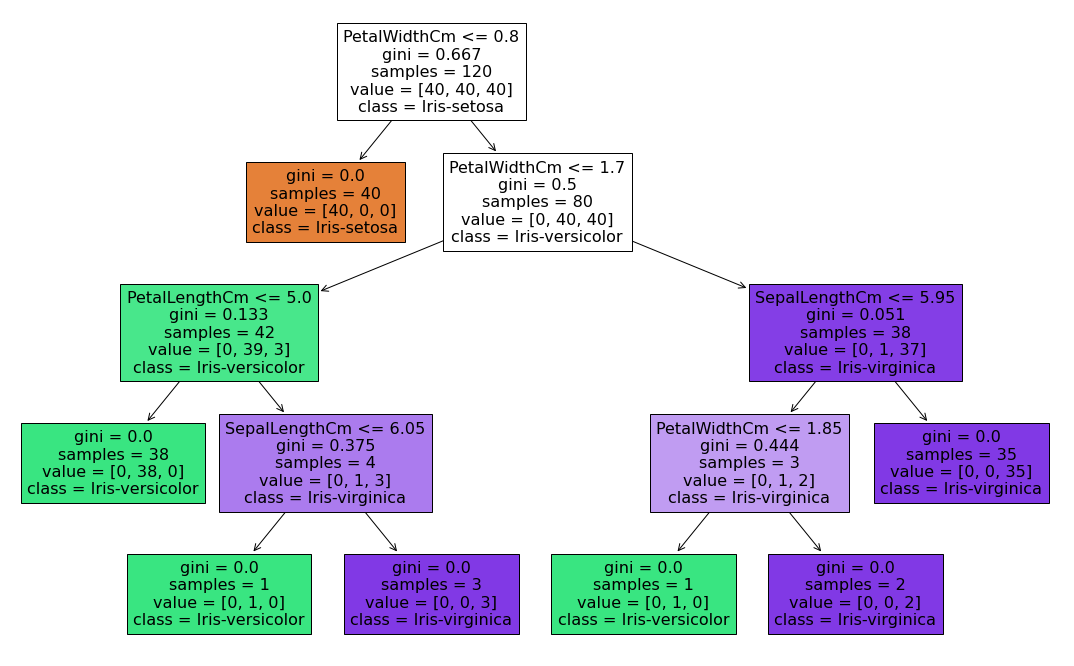

In [10]:
from sklearn.tree import plot_tree
plt.figure(figsize=(19,12))
features = df.columns
classes = ['Iris-setosa','Iris-versicolor', 'Iris-virginica']
plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

In [11]:
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

In [12]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 1.0
Test score 0.8666666666666667


Train Confusion matrix


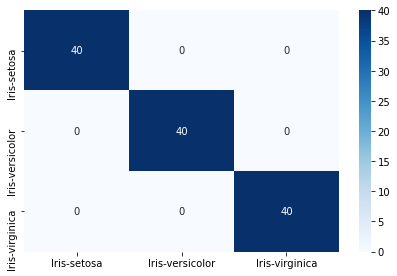

Test Confusion matrix


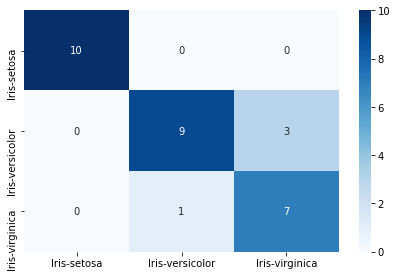

In [13]:
#Plotting Confusion Matrix
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

###### We can see that in our train data we have 100% accuracy and in test data we have 86.67% accuracy, which clearly depicts that our model is overfitting. Thus, we will use pruning to overcome this issue. We will see both pruning methods and their effect on the model one by one.

## 1. Pre-pruning

Pre pruning is nothing but stoping the growth of decision tree on an early stage. We will use GridSearchCV to choose optimum values for paramemters limiting the growth of trees.

In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = DecisionTreeClassifier()
gscv = GridSearchCV(estimator=clf,param_grid=params)
gscv.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [15]:
model = gscv.best_estimator_
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 1.0
Test score 0.9333333333333333


Train Confusion matrix


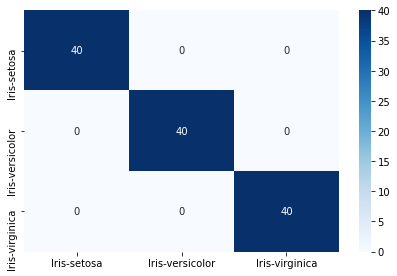

Test Confusion matrix


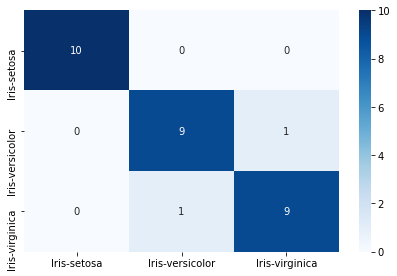

In [16]:
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

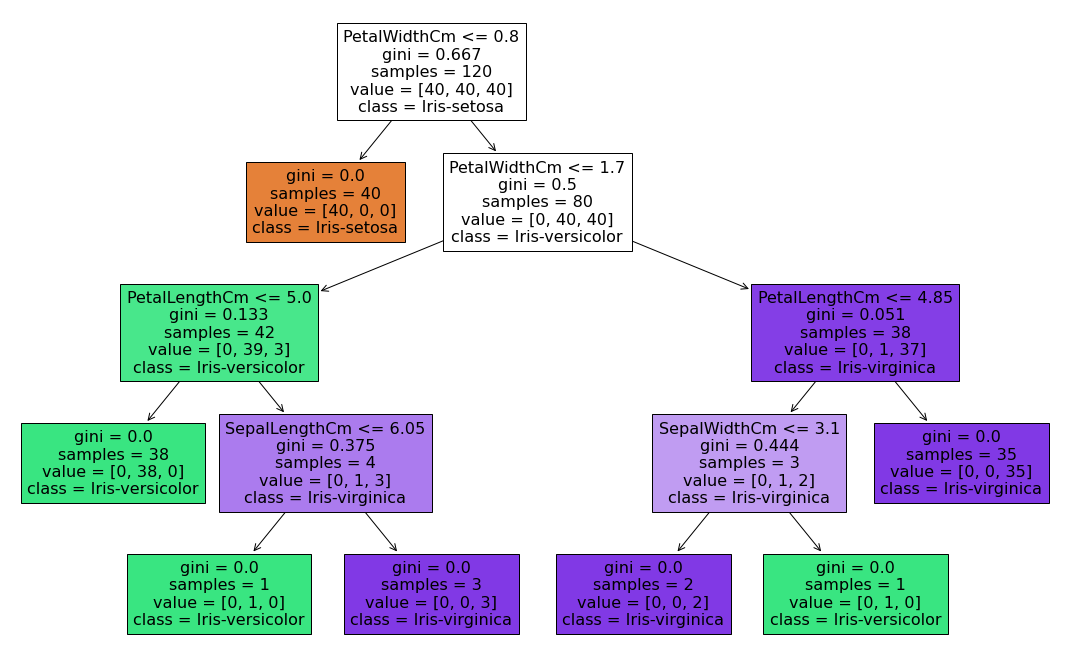

In [17]:
plt.figure(figsize=(19,12))
features = df.columns
classes = ['Iris-setosa','Iris-versicolor', 'Iris-virginica']
plot_tree(model,feature_names=features,class_names=classes,filled=True)
plt.show()

###### We can see that tree is pruned and there is improvement in test accuracy. But still there is a scope of improvement.

## 2. Post-pruning 

We will use Cost Complexity Pruning Technique for post pruning process

In [18]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00811404 0.0125     0.03392857 0.27067669 0.33333333]


In [19]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

We will remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.

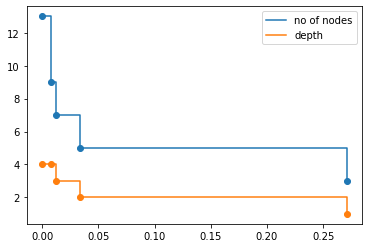

In [20]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

###### Observation: As alpha increases no of nodes and depth decreases

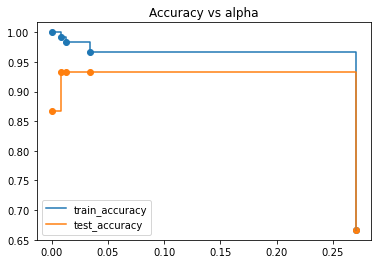

In [21]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

###### We can choose alpha = 0.05 as we get the maximum Test Accuracy = 0.93 along with optimum train accuracy there. Although our Train Accuracy has decreased to 0.96, our model is now more generalized and it will perform better on unseen data.

In [22]:
clf_ = DecisionTreeClassifier(random_state=0,ccp_alpha=0.05)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.9666666666666667
Test score 0.9333333333333333


Train Confusion matrix


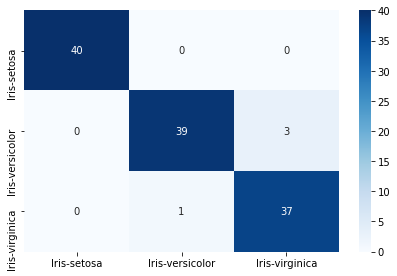

Test Confusion matrix


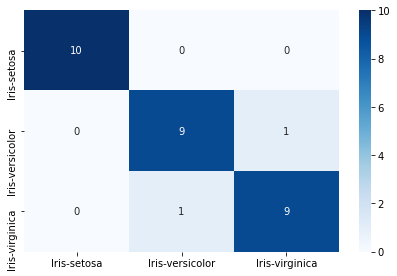

In [23]:
plot_confusionmatrix(y_train_pred,y_train,dom='Train')
plot_confusionmatrix(y_test_pred,y_test,dom='Test')

###### We can see that now our model is not overfiting and performance on test data has improved.

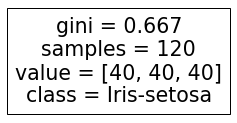

In [24]:
plt.figure(figsize=(4,2))
features = df.columns
classes = ['Iris-setosa','Iris-versicolor', 'Iris-virginica']
plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

### We can see that the size of decision tree significantly got reduced. It can also be observed that postpruning is much efficient than prepruning.

##### Note: In this notebook we have used accuracy as metric. But metrics like AUC, ROC, F1 score, etc can also be used for evaluation.